<a href="https://colab.research.google.com/github/ns-0437/Stock-Price-Forecasting/blob/main/stock_price_prediction_nvda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock price prediction

## Importing libraries

### Pandas

In [3]:
import pandas as pd

### NumPy

In [4]:
import numpy as np

### Matplotlib

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mandates

### SciKit-Learn

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

### Keras (Tensorflow)

In [8]:
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam  # Correct optimizer import
from tensorflow.keras.utils import plot_model  # Correct plot_model import


## Visualise dataset

### Load dataset

In [9]:
df = pd.read_csv('/content/nvda_stock_history.csv', na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)

<ipython-input-9-13e09630932e>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv('/content/nvda_stock_history.csv', na_values=['null'], index_col='Date', parse_dates=True, infer_datetime_format=True)


### Print dataset's head

In [10]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376358,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415786,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383527,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382332,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381137,22752000


## Clean dataset

### Display dataset's head

In [11]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376358,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415786,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383527,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382332,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381137,22752000


### Checking is there is any `null` values

In [12]:
df.isnull().values.any()

np.False_

### Fill the missing values using the mean of the column

In [13]:
df.fillna(df.mean(), inplace=True)

### Double check to see if we filled all the missing values

In [14]:
df.isnull().values.any()

np.False_

## Visualising data

### Plotting the true Adjusted Close value

In [15]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

<Axes: xlabel='Date'>

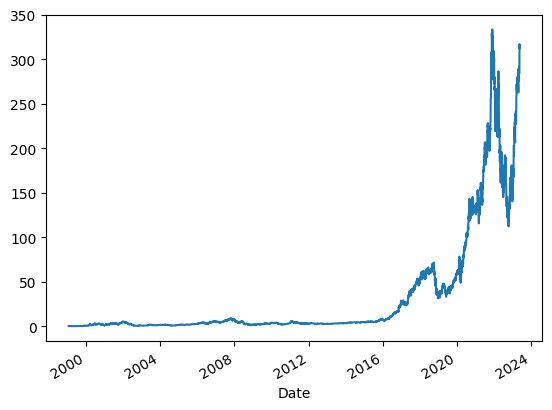

In [16]:
df['Adj Close'].plot()

## Setting the data for the model

### Set up the target variable and the features

In [17]:
# Value of the stock at the end of the day to predict
predict = pd.DataFrame(df['Adj Close'])

# Features to use to predict the value of the stock
features = ['Open', 'High', 'Low', 'Volume']

### Scaling the data

In [18]:
scaler = MinMaxScaler()
features_normalised = scaler.fit_transform(df[features])
features_normalised = pd.DataFrame(columns=features, data=features_normalised, index=df.index)
features_normalised.head()

,Open,High,Low,Volume
Date,,,,
1999-01-22,0.000264,0.000384,0.000171,0.292580
1999-01-25,0.000280,0.000297,0.000240,0.053283
1999-01-26,0.000327,0.000324,0.000244,0.035123
1999-01-27,0.000210,0.000214,0.000195,0.024393
1999-01-28,0.000202,0.000184,0.000248,0.022564


## Training

### Create training set and testing set

In [19]:
timesplit = TimeSeriesSplit(n_splits=10)

for training_index, test_index in timesplit.split(features_normalised):
    X_train, X_test = features_normalised[:len(training_index)], features_normalised[len(training_index): (len(training_index)+len(test_index))]
    y_train, y_test = predict[:len(training_index)].values.ravel(), predict[len(training_index): (len(training_index)+len(test_index))].values.ravel()

### Data processing for LSTM

In [20]:
train_X = np.array(X_train)
test_X = np.array(X_test)

X_train = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
X_test = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

### LSTM preparation

In [21]:
lstm = Sequential()
lstm.add(LSTM(128, activation='relu', input_shape=(1, train_X.shape[1]), return_sequences=False))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


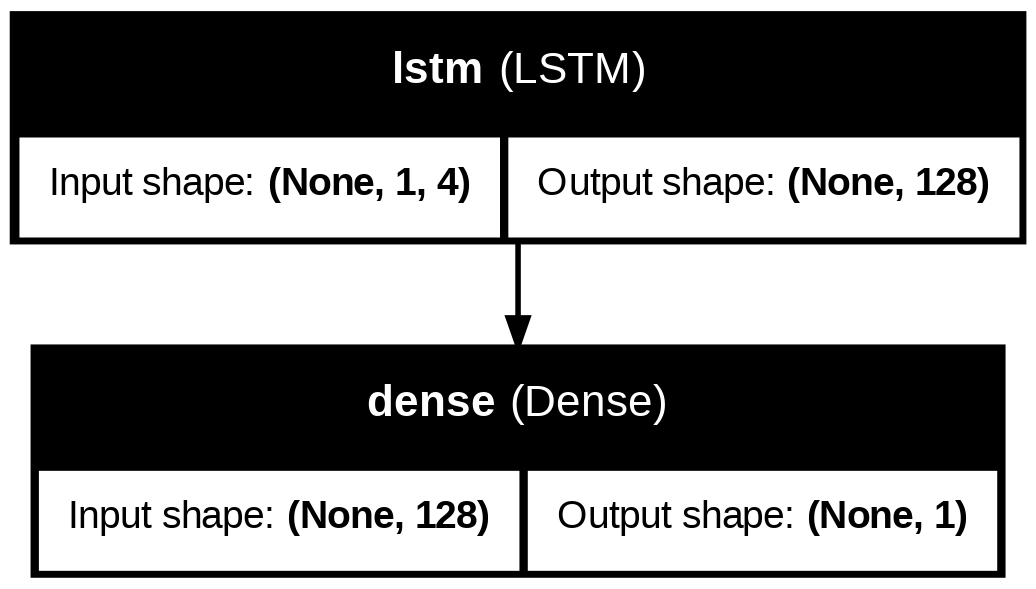

In [22]:
plot_model(lstm, show_shapes=True, show_layer_names=True)

### Model training

In [23]:
history = lstm.fit(X_train, y_train, epochs=100, batch_size=16, shuffle=False, verbose=1)

Epoch 1/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 43.6121
Epoch 2/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 93.5262
Epoch 3/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 144.6494
Epoch 4/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 184.4687
Epoch 5/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 198.6859
Epoch 6/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 195.9873
Epoch 7/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 182.7909
Epoch 8/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 161.7822
Epoch 9/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 133.9047
Epoch 10/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 101.8573
Epoch 11/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 71.0661
Epoch 12/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 46.1894
Epoch 13/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 28.4447
Epoch 14/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 16.9673
Epoch 15/100
348/348 

## Prediction

In [24]:
y_pred = lstm.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


## Result plotting and evaluation

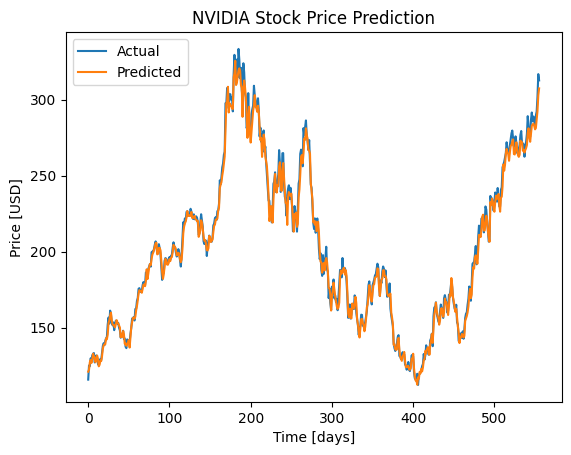

In [25]:
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price [USD]')
plt.legend()
plt.show()

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict on test data
y_pred = lstm.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Mean Squared Error (MSE): 22.02919429628495
Root Mean Squared Error (RMSE): 4.693526850491531
R² Score: 0.9923490174812026


In [27]:
# Convert predictions and actual values into up/down movements
y_test_direction = np.sign(np.diff(y_test.flatten()))  # Actual movement (+1 or -1)
y_pred_direction = np.sign(np.diff(y_pred.flatten()))  # Predicted movement (+1 or -1)

# Calculate accuracy as percentage of correctly predicted movements
direction_accuracy = np.mean(y_test_direction == y_pred_direction) * 100

print(f"Trend Direction Accuracy: {direction_accuracy:.2f}%")


Trend Direction Accuracy: 74.05%
